In [264]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
import sectionate
import xarray as xr
import numpy as np
import matplotlib.pylab as plt

# Computing velocity-grid following sections with `sectionate`

In this example, we use the `sectionate.create_composite_section` function to find the grid cell indices for the series of grid cell faces that best approximate a hydrographic section input by the user. In this case, we consider both the West and East sections of the *Overturning of the Subpolar North Atlantic (OSNAP)* observational program.

We consider both cases of the memory MOM6 memory models: symmetric (excluding the cell faces at the western and southern edges of the domain; also used in MOM5 and the MITgcm C-grids) and non-symmetric (including all tracer cell faces).

## 1. Symmetric grid example (CM2)

### Load the model grid

In [266]:
grid = xr.open_dataset('grid_CM2_minimal.nc')
symmetric = grid['geolon_c'].shape==grid['geolon_t'].shape
symmetric

True

### Define section start, end, and some intermediate points to capture the general structure

In [267]:
West_section_lats=[52.0166, 52.6648, 53.5577, 58.8944, 60.4000]
West_section_lons=[-56.8775, -52.0956, -49.8604, -47.6107, -44.8000]

Behind the scenes, `sectionate.create_section_composite` iterates through each of the consecutive linear segments in the section and uses `sectionate.create_section` to approximate them with the closest series of consecutive points on the vorticity grid (i.e. following the cell faces on which velocities are defined).

In [268]:
iwest,jwest,xwest,ywest = sectionate.create_section_composite(grid['geolon_c'], grid['geolat_c'], West_section_lons, West_section_lats, symmetric)

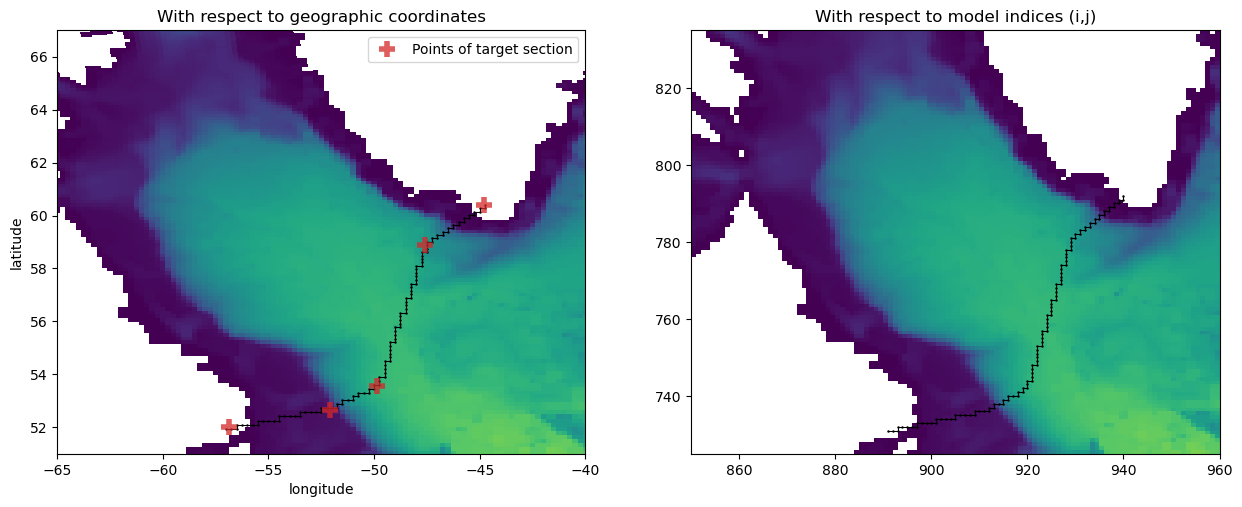

In [269]:
plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(grid['geolon_t'], grid['geolat_t'], grid['ht'][1::,1::])
plt.plot(xwest, ywest, 'k.-', markersize=1.5, lw=0.75)
plt.plot(West_section_lons, West_section_lats, "C3+", markersize=12., mew=4., alpha=0.75, label="Points of target section")
plt.axis([-65,-40, 51, 67])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(grid['ht'].values)
plt.plot(iwest, jwest, 'k.-', markersize=1.5, lw=0.75)
plt.axis([850,960, 725, 835])
plt.title("With respect to model indices (i,j)")
plt.show()

In [270]:
CM2_dim_names = {"xh":"xt_ocean", "yh":"yt_ocean", "xq":"xu_ocean", "yq":"yu_ocean"}

uvindices = sectionate.transports.uvindices_from_qindices(iwest, jwest, symmetric)
lons, lats = sectionate.transports.uvcoords_from_uvindices(
    grid,
    uvindices,
    dim_names = CM2_dim_names
)

#### Define an orientation such that transports are defined as positive if they are convergent in a counter-clockwise sense

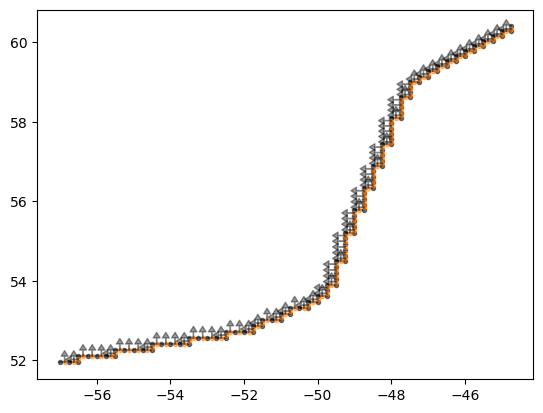

In [271]:
plt.plot(xwest, ywest, "ko-", alpha=0.5, markersize=3, label="tracer cell corners (vorticity grid)")
plt.plot(lons, lats, "C1o", alpha=0.5, lw=1, markersize=3, label="velocity cells (faces normal to section)")
for (p, (var, lon, lat, nward, eward)) in enumerate(zip(uvindices['var'], lons, lats, uvindices['nward'], uvindices['eward'])):
    if var=="V":
        efact = 0.
        nfact = -1 if not(eward) else 1
    if var=="U":
        efact = -1 if nward else 1
        nfact = 0.

    plt.annotate('', xy=(lon+float(efact)*0.35, lat+float(nfact)*0.3),  xycoords='data',
            xytext=(lon, lat),
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.25, headwidth=5., headlength=4., alpha=0.4),
            horizontalalignment='center', verticalalignment='center',
            )
    

## 2. Non-symmetric grid example (CM4)

### Load the model grid

In [272]:
dir_pp = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_test_v6_proto2/gfdl.ncrc4-intel18-prod-openmp/pp/'
grid = xr.open_dataset(f"{dir_pp}/ocean_annual_rho2_d2/ocean_annual_rho2_d2.static.nc")
grid['geolon_c'][:,-1] = grid['geolon_c'][:,0]+360. # correct geo coordinates for nonsymmetric static grids!
grid['geolat_c'][:,-1] = grid['geolat_c'][:,0]
symmetric = grid['geolon_c'].shape==grid['geolon'].shape
symmetric

False

### Define section start, end, and some intermediate points to capture the general structure

In [273]:
West_section_lats=[52.0166, 52.6648, 53.5577, 58.8944, 60.4000]
West_section_lons=[-56.8775, -52.0956, -49.8604, -47.6107, -44.8000]
East_section_lats=[60.3000, 58.8600, 58.0500, 58.0000, 56.5000]
East_section_lons=[-44.9000, -30.5400, -28.0000, -14.7000, -5.9300]

We iterate on each linear segment of the section to better follow the path of the ship. We use `sectionate.create_section` to find the path of adjacent tracer cell indices that most closely follow each segment. The sub-sections for each linear segment are then appended to common arrays to build the full section.

**Note:** the last point of a segment is removed to not duplicate the first point of the following segment.



In [274]:
iwest,jwest,xwest,ywest = sectionate.create_section_composite(grid['geolon_c'], grid['geolat_c'], West_section_lons, West_section_lats, symmetric)

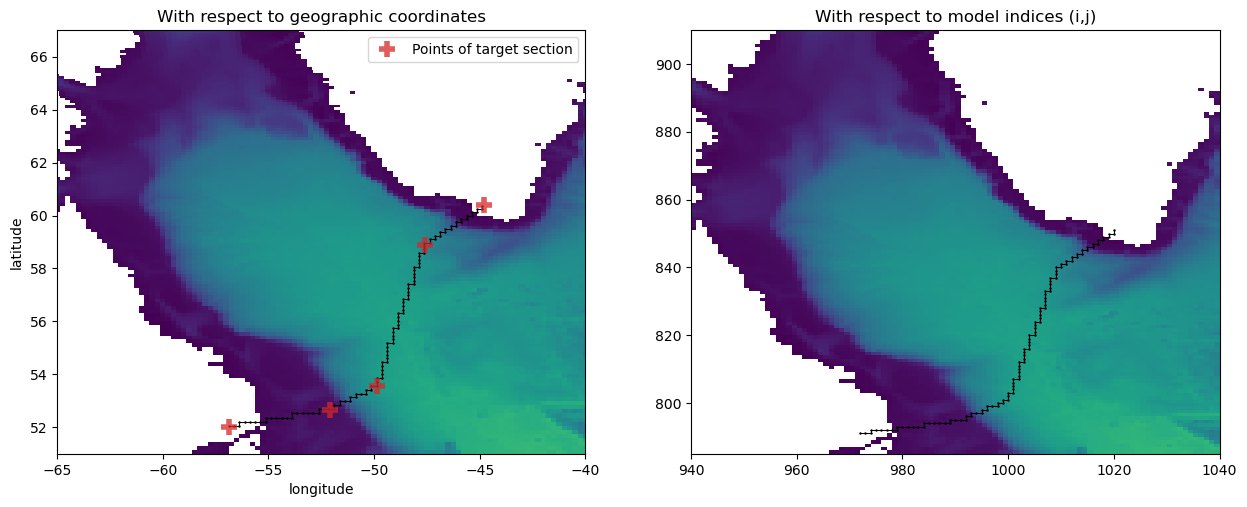

In [275]:
plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(grid['geolon_c'], grid['geolat_c'], grid['deptho'].where(grid['deptho']!=0))
plt.plot(xwest, ywest, 'k.-', markersize=1.5, lw=0.75)
plt.plot(West_section_lons, West_section_lats, "C3+", markersize=12., mew=4., alpha=0.75, label="Points of target section")
plt.axis([-65,-40, 51, 67])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(grid['deptho'].where(grid['deptho']!=0).values)
plt.plot(iwest, jwest, 'k.-', markersize=1.5, lw=0.75)
plt.axis([940, 1040, 785, 910])
plt.title("With respect to model indices (i,j)")
plt.show()

In [276]:
uvindices = sectionate.transports.uvindices_from_qindices(iwest, jwest, symmetric)
lons, lats = sectionate.transports.uvcoords_from_uvindices(
    grid,
    uvindices
)

#### Define an orientation such that transports are defined as positive if they are convergent in a counter-clockwise sense

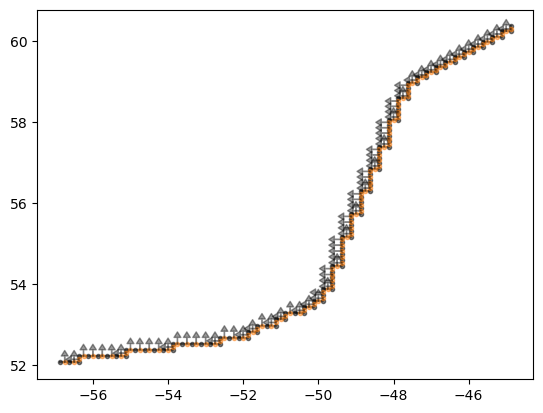

In [277]:
plt.plot(xwest, ywest, "ko-", alpha=0.5, markersize=3, label="tracer cell corners (vorticity grid)")
plt.plot(lons, lats, "C1o", alpha=0.5, lw=1, markersize=3, label="velocity cells (faces normal to section)")
for (p, (var, lon, lat, nward, eward)) in enumerate(zip(uvindices['var'], lons, lats, uvindices['nward'], uvindices['eward'])):
    if var=="V":
        efact = 0.
        nfact = -1 if not(eward) else 1
    if var=="U":
        efact = -1 if nward else 1
        nfact = 0.

    plt.annotate('', xy=(lon+float(efact)*0.35, lat+float(nfact)*0.3),  xycoords='data',
            xytext=(lon, lat),
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.25, headwidth=5., headlength=4., alpha=0.4),
            horizontalalignment='center', verticalalignment='center',
            )